**Задание**

Возьмите датасет https://www.kaggle.com/datasets/ajayrana/hymenoptera-data/code

- Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)
- Обучите на нем модели ResNet 18 и VGG 16 с использованием Fine-tuning (5-10 эпох)
- Добавьте аугментацию данных к пункту 2
- Сравните качество всех 3 полученных подходов

In [ ]:
import torch
from torch import nn
import torchvision as tv
import time

import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as tfs
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np
import os
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [ ]:
BATCH_SIZE = 4
NUM_EPOCHS = 5
LR = 0.01
data_dir = "/content/drive/MyDrive/Colab Notebooks/ds/hymenoptera_data"

In [ ]:
data_tfs = {
    'train': tfs.Compose([
        tfs.Resize((227,227)),
        tfs.ToTensor()
    ]),
    'val': tfs.Compose([
        tfs.Resize((227,227)),
        tfs.ToTensor()
    ]),
}

dataset = {ds: tv.datasets.ImageFolder(root=os.path.join(data_dir, ds), transform=data_tfs[ds]) for ds in ['train', 'val']}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'val']}
dataset_classes = dataset['train'].classes
print('classes:', dataset_classes, '\nsize', dataset_size)

classes: ['ants', 'bees'] 
size {'train': 244, 'val': 153}


In [ ]:
train_iter = torch.utils.data.DataLoader(dataset=dataset['train'], batch_size=BATCH_SIZE, shuffle=True)
test_iter =  torch.utils.data.DataLoader(dataset=dataset['val'], batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
for X, y in train_iter:
    print(X.shape, y.shape)
    break

for X, y in test_iter:
    print(X.shape, y.shape)
    break

torch.Size([4, 3, 227, 227]) torch.Size([4])
torch.Size([4, 3, 227, 227]) torch.Size([4])


In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = torch.nn.CrossEntropyLoss(reduction='sum')

    for epoch in range(1, num_epochs+1):
        start=time.time()
        train_loss, train_acc, train_n = 0., 0., 0
        test_loss, test_acc, test_n = 0., 0., 0
    
        net.train()
        for X, y in train_iter:
            trainer.zero_grad()
            y_pred = net(X)
            l = loss(y_pred, y)
            l.backward()
            trainer.step()
            train_loss += l.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()
            train_n += len(X)
    
        net.eval()
        for X, y in test_iter:
            y_pred = net(X)
            l = loss(y_pred, y)
            test_loss += l.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item()
            test_n += len(X)
        
        print("\nepoch: {}, taked: {:.2f}, train_loss: {:.3f}, train_acc: {:.2f}%, test_loss: {:.3f}, test_acc: {:.2f}%".format(
            epoch, time.time() - start, train_loss / train_n, train_acc / train_n *100 , test_loss / test_n, test_acc / test_n *100))

In [ ]:
resnet18 = tv.models.resnet18(pretrained=False)
trainer = torch.optim.Adam(resnet18.parameters(), LR)
resnet18.fc = nn.Linear(in_features=512, out_features=2)

train(resnet18, train_iter, test_iter, trainer, NUM_EPOCHS)


epoch: 1, taked: 63.40, train_loss: 0.965, train_acc: 53.28%, test_loss: 1.283, test_acc: 59.48%

epoch: 2, taked: 59.99, train_loss: 0.763, train_acc: 51.23%, test_loss: 0.673, test_acc: 59.48%

epoch: 3, taked: 62.56, train_loss: 0.697, train_acc: 55.74%, test_loss: 0.888, test_acc: 62.75%

epoch: 4, taked: 59.91, train_loss: 0.714, train_acc: 57.79%, test_loss: 0.810, test_acc: 56.86%

epoch: 5, taked: 59.69, train_loss: 0.666, train_acc: 61.89%, test_loss: 0.692, test_acc: 66.01%


In [ ]:
vgg16 = models.vgg16(pretrained=False)
trainer = torch.optim.Adam(vgg16.parameters(), LR)
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2)

train(vgg16, train_iter, test_iter, trainer, NUM_EPOCHS)


epoch: 1, taked: 431.51, train_loss: 105288862.063, train_acc: 51.23%, test_loss: 0.721, test_acc: 45.75%

epoch: 2, taked: 428.89, train_loss: 0.908, train_acc: 51.64%, test_loss: 0.698, test_acc: 45.75%

epoch: 3, taked: 427.02, train_loss: 0.711, train_acc: 50.00%, test_loss: 0.715, test_acc: 45.75%

epoch: 4, taked: 424.93, train_loss: 0.705, train_acc: 50.82%, test_loss: 0.693, test_acc: 45.75%

epoch: 5, taked: 425.84, train_loss: 0.701, train_acc: 53.28%, test_loss: 0.699, test_acc: 45.75%


In [ ]:
resnet18_pret = tv.models.resnet18(pretrained=True)
resnet18_pret

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resnet18_pret.parameters():
    param.requires_grad = False

In [ ]:
resnet18_pret.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
resnet18_pret.fc = nn.Linear(in_features=512, out_features=2)

In [ ]:
print("Params to learn:")
params_to_update = []
for name,param in resnet18_pret.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
train(resnet18_pret, train_iter, test_iter, trainer, NUM_EPOCHS)


epoch: 1, taked: 28.39, train_loss: 0.658, train_acc: 58.61%, test_loss: 0.485, test_acc: 76.47%

epoch: 2, taked: 28.17, train_loss: 0.470, train_acc: 79.10%, test_loss: 0.356, test_acc: 85.62%

epoch: 3, taked: 28.12, train_loss: 0.427, train_acc: 78.69%, test_loss: 0.352, test_acc: 86.93%

epoch: 4, taked: 28.30, train_loss: 0.497, train_acc: 73.36%, test_loss: 0.277, test_acc: 91.50%

epoch: 5, taked: 28.96, train_loss: 0.424, train_acc: 80.74%, test_loss: 0.354, test_acc: 86.27%


In [ ]:
vgg16_pret = tv.models.vgg16(pretrained=True)
vgg16_pret

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in vgg16_pret.parameters():
    param.requires_grad = False

vgg16_pret.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
vgg16_pret.classifier[6] = nn.Linear(in_features=4096, out_features=2)

In [ ]:
print("Params to learn:")
params_to_update = []
for name,param in vgg16_pret.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)


Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
train(vgg16_pret, train_iter, test_iter, trainer, NUM_EPOCHS)


epoch: 1, taked: 164.61, train_loss: 0.437, train_acc: 81.97%, test_loss: 0.299, test_acc: 87.58%

epoch: 2, taked: 163.85, train_loss: 0.200, train_acc: 93.85%, test_loss: 0.317, test_acc: 86.27%

epoch: 3, taked: 165.14, train_loss: 0.153, train_acc: 94.26%, test_loss: 0.344, test_acc: 86.27%

epoch: 4, taked: 163.19, train_loss: 0.151, train_acc: 93.85%, test_loss: 0.300, test_acc: 87.58%

epoch: 5, taked: 165.50, train_loss: 0.104, train_acc: 96.31%, test_loss: 0.346, test_acc: 87.58%


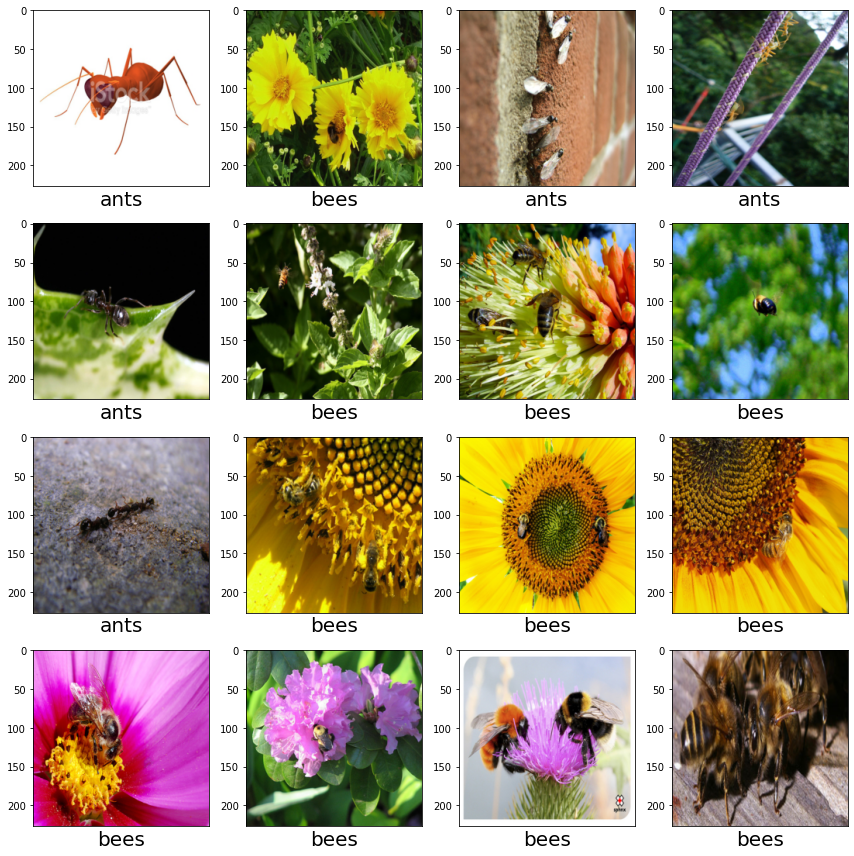

In [ ]:
def get_batches(dataloader, num_of_batches=4):
    assert(num_of_batches > 0)
    images, classes = next(iter(dataloader))
    for _ in range(num_of_batches - 1):
        image_batch, cls_batch = next(iter(dataloader))
        images = torch.cat([images, image_batch], dim=0)
        classes = torch.cat([classes, cls_batch], dim=0)
    return images, classes

def show_batches(images, classes):
    cols = (images.shape[0] + 3) // 4
    images = images.numpy().transpose(0,2,3,1)
    fig, axes = plt.subplots(cols, 4, figsize=(12, cols * 3))
    for ax, img, img_cls in zip(axes.flatten(), images, classes.numpy()):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_xlabel(dataset_classes[img_cls], fontsize=20)
    plt.tight_layout()
    plt.show()

images, classes = get_batches(torch.utils.data.DataLoader(dataset=dataset['train'], batch_size=4, shuffle=True))
show_batches(images, classes)

classes: ['ants', 'bees'] 
size {'train': 244, 'val': 153}


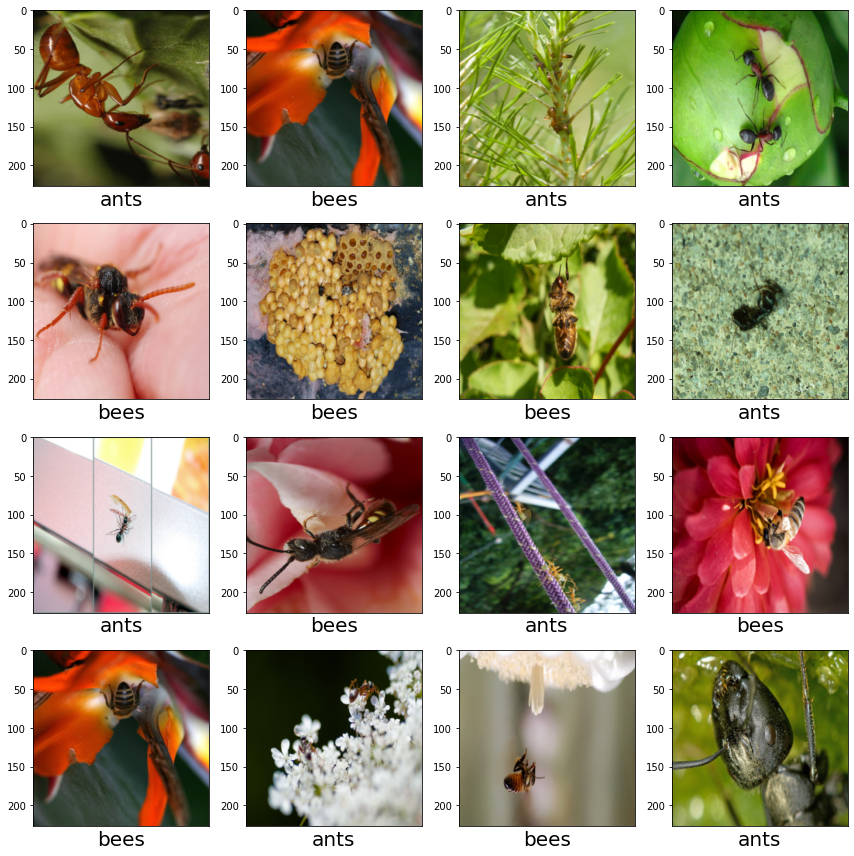

In [ ]:
data_tfs_aug = {
    'train': tfs.Compose([
        tfs.Resize((227,227)),
        #tfs.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2)),
        tfs.RandomHorizontalFlip(),
        tfs.RandomVerticalFlip(),
        tfs.ToTensor()
    ]),
    'val': tfs.Compose([
        tfs.Resize((227,227)),
        tfs.ToTensor()
    ]),
}

dataset_aug = {ds: tv.datasets.ImageFolder(root=os.path.join(data_dir, ds), transform=data_tfs_aug[ds]) for ds in ['train', 'val']}
dataset_size_aug = {ds: len(dataset_aug[ds]) for ds in ['train', 'val']}
dataset_classes_aug = dataset_aug['train'].classes
print('classes:', dataset_classes_aug, '\nsize', dataset_size_aug)

loader = torch.utils.data.DataLoader(dataset_aug['train'], batch_size=4, shuffle=True)

images, classes = get_batches(loader)
show_batches(images, classes)

In [ ]:
train_iter_aug = torch.utils.data.DataLoader(dataset=dataset_aug['train'], batch_size=BATCH_SIZE, shuffle=True)
test_iter_aug = torch.utils.data.DataLoader(dataset=dataset_aug['val'], batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
resnet18_pret_aug = tv.models.resnet18(pretrained=True)

for param in resnet18_pret_aug.parameters():
    param.requires_grad = False

resnet18_pret_aug.fc = nn.Linear(in_features=512, out_features=2)

params_to_update = []
for name,param in resnet18_pret_aug.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

trainer = torch.optim.Adam(params_to_update, lr=0.001)

train(resnet18_pret_aug, train_iter_aug, test_iter_aug, trainer, NUM_EPOCHS)


epoch: 1, taked: 28.61, train_loss: 0.561, train_acc: 75.82%, test_loss: 0.374, test_acc: 90.20%

epoch: 2, taked: 28.33, train_loss: 0.469, train_acc: 78.69%, test_loss: 0.297, test_acc: 91.50%

epoch: 3, taked: 28.53, train_loss: 0.450, train_acc: 77.87%, test_loss: 0.275, test_acc: 90.85%

epoch: 4, taked: 29.39, train_loss: 0.377, train_acc: 84.02%, test_loss: 0.557, test_acc: 72.55%

epoch: 5, taked: 28.52, train_loss: 0.496, train_acc: 75.82%, test_loss: 0.282, test_acc: 90.85%


In [ ]:
vgg16_pret_aug = tv.models.vgg16(pretrained=True)

for param in vgg16_pret_aug.parameters():
    param.requires_grad = False

vgg16_pret_aug.classifier[6] = nn.Linear(in_features=4096, out_features=2)

params_to_update = []
for name,param in vgg16_pret_aug.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

trainer = torch.optim.Adam(params_to_update, lr=0.001)

train(vgg16_pret_aug, train_iter_aug, test_iter_aug, trainer, NUM_EPOCHS)


epoch: 1, taked: 166.31, train_loss: 0.438, train_acc: 79.92%, test_loss: 0.280, test_acc: 88.89%

epoch: 2, taked: 165.22, train_loss: 0.265, train_acc: 89.75%, test_loss: 0.268, test_acc: 87.58%

epoch: 3, taked: 165.54, train_loss: 0.216, train_acc: 93.85%, test_loss: 0.255, test_acc: 90.20%

epoch: 4, taked: 172.88, train_loss: 0.199, train_acc: 93.85%, test_loss: 0.267, test_acc: 88.89%

epoch: 5, taked: 165.08, train_loss: 0.151, train_acc: 93.44%, test_loss: 0.353, test_acc: 86.27%


|net| accuracy|c нуля |pretrain	|pretrain aug	|
|:------|:------|------:|------:|------:|
|ResNet18|train_acc|61.89|80.74|75.82|
||test_acc|66.01|86.27|90.85|
|VGG16|train_acc|53.28|96.31|93.44|
||test_acc|45.75|87.58|86.27|


